In [1]:
pip install pulp

     --------------------------------------- 14.3/14.3 MB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
import pickle

C:\Users\91909\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\91909\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\91909\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
turns = pd.DataFrame({
    'turn_no':[1,2,3,4,5],
    'from_country':['GB','GB','US','TR','RU'],
    'to_country':['CZ','CZ','CZ','FR','FR'],
    'plane_size':[2,3,2,1,1]
    }, columns=['turn_no', 'plane_size', 'from_country', 'to_country'])

airport = pd.DataFrame({
    'terminal':['A','A','A','B','C', 'C'],
    'gate':['A1','A2','A3','B1','C1','C2'],
    'max_size':[3,1,2,3,1,1]
    }, columns = ['terminal', 'gate', 'max_size'])

In [4]:
airport

,terminal,gate,max_size
0,A,A1,3
1,A,A2,1
2,A,A3,2
3,B,B1,3
4,C,C1,1
5,C,C2,1


In [5]:
turns

,turn_no,plane_size,from_country,to_country
0,1,2,GB,CZ
1,2,3,GB,CZ
2,3,2,US,CZ
3,4,1,TR,FR
4,5,1,RU,FR


In [6]:
turn_list = turns.turn_no.to_numpy()
print("Turns to allocate: ", turn_list)

Turns to allocate:  [1 2 3 4 5]


In [7]:
gate_list = airport.gate.to_numpy()
print("Available gates: ", gate_list)

Available gates:  ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']


In [8]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    for g in gate_list:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list) == 1

# ii. Gates cannot have more than one turn/plane
for g in gate_list:
    prob += lpSum(x[t, g] for t in turn_list) <= 1
    
# Formula
print(prob)

# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

C:\Users\91909\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Airport_Gate_Allocation:
MINIMIZE
0
SUBJECT TO
_C1: t1_gA1 + t1_gA2 + t1_gA3 + t1_gB1 + t1_gC1 + t1_gC2 = 1

_C2: t2_gA1 + t2_gA2 + t2_gA3 + t2_gB1 + t2_gC1 + t2_gC2 = 1

_C3: t3_gA1 + t3_gA2 + t3_gA3 + t3_gB1 + t3_gC1 + t3_gC2 = 1

_C4: t4_gA1 + t4_gA2 + t4_gA3 + t4_gB1 + t4_gC1 + t4_gC2 = 1

_C5: t5_gA1 + t5_gA2 + t5_gA3 + t5_gB1 + t5_gC1 + t5_gC2 = 1

_C6: t1_gA1 + t2_gA1 + t3_gA1 + t4_gA1 + t5_gA1 <= 1

_C7: t1_gA2 + t2_gA2 + t3_gA2 + t4_gA2 + t5_gA2 <= 1

_C8: t1_gA3 + t2_gA3 + t3_gA3 + t4_gA3 + t5_gA3 <= 1

_C9: t1_gB1 + t2_gB1 + t3_gB1 + t4_gB1 + t5_gB1 <= 1

_C10: t1_gC1 + t2_gC1 + t3_gC1 + t4_gC1 + t5_gC1 <= 1

_C11: t1_gC2 + t2_gC2 + t3_gC2 + t4_gC2 + t5_gC2 <= 1

VARIABLES
0 <= t1_gA1 <= 1 Integer
0 <= t1_gA2 <= 1 Integer
0 <= t1_gA3 <= 1 Integer
0 <= t1_gB1 <= 1 Integer
0 <= t1_gC1 <= 1 Integer
0 <= t1_gC2 <= 1 Integer
0 <= t2_gA1 <= 1 Integer
0 <= t2_gA2 <= 1 Integer
0 <= t2_gA3 <= 1 Integer
0 <= t2_gB1 <= 1 Integer
0 <= t2_gC1 <= 1 Integer
0 <= t2_gC2 <= 1 Integer
0 <= t3

In [10]:
# Some gates may not be able to fit a plane
# Assume gate with max_size k can fit a plane_size of j <= k

compatible_gates = {}
for idx, row in turns.iterrows():
    gates_lst = airport[airport.max_size >= row.plane_size].gate.to_numpy()
    compatible_gates[row.turn_no] = gates_lst

print("Compatible gates for each turn")
for k, v in compatible_gates.items():
    print(k, v)

# And inverse ... 
#compatible_turns = {}
#for k, v in compatible_gates.items():
#    for gate in v:
#        compatible_turns.setdefault(gate, [])
#        compatible_turns[gate].append(k)
#
#print("Compatible turns for each gate")
#for k, v in compatible_turns.items():
#    print(k, v)
#        
# Now we can add this to the model ...

Compatible gates for each turn
1 ['A1' 'A3' 'B1']
2 ['A1' 'B1']
3 ['A1' 'A3' 'B1']
4 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
5 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']


In [11]:
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # The 'constraint' gets added implicitly by not creating a choice variable that
    # connects turns to incompatible gates
    # As opposed to adding it as a constraint
    for g in compatible_gates[t]:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1

# ii. Gates cannot have more than one turn/plane
for g in gate_list:
    prob += lpSum(x[t, g] for t in turn_list if (t, g) in x) <= 1
    
# Formula
print(prob)

# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

Airport_Gate_Allocation:
MINIMIZE
0
SUBJECT TO
_C1: t1_gA1 + t1_gA3 + t1_gB1 = 1

_C2: t2_gA1 + t2_gB1 = 1

_C3: t3_gA1 + t3_gA3 + t3_gB1 = 1

_C4: t4_gA1 + t4_gA2 + t4_gA3 + t4_gB1 + t4_gC1 + t4_gC2 = 1

_C5: t5_gA1 + t5_gA2 + t5_gA3 + t5_gB1 + t5_gC1 + t5_gC2 = 1

_C6: t1_gA1 + t2_gA1 + t3_gA1 + t4_gA1 + t5_gA1 <= 1

_C7: t4_gA2 + t5_gA2 <= 1

_C8: t1_gA3 + t3_gA3 + t4_gA3 + t5_gA3 <= 1

_C9: t1_gB1 + t2_gB1 + t3_gB1 + t4_gB1 + t5_gB1 <= 1

_C10: t4_gC1 + t5_gC1 <= 1

_C11: t4_gC2 + t5_gC2 <= 1

VARIABLES
0 <= t1_gA1 <= 1 Integer
0 <= t1_gA3 <= 1 Integer
0 <= t1_gB1 <= 1 Integer
0 <= t2_gA1 <= 1 Integer
0 <= t2_gB1 <= 1 Integer
0 <= t3_gA1 <= 1 Integer
0 <= t3_gA3 <= 1 Integer
0 <= t3_gB1 <= 1 Integer
0 <= t4_gA1 <= 1 Integer
0 <= t4_gA2 <= 1 Integer
0 <= t4_gA3 <= 1 Integer
0 <= t4_gB1 <= 1 Integer
0 <= t4_gC1 <= 1 Integer
0 <= t4_gC2 <= 1 Integer
0 <= t5_gA1 <= 1 Integer
0 <= t5_gA2 <= 1 Integer
0 <= t5_gA3 <= 1 Integer
0 <= t5_gB1 <= 1 Integer
0 <= t5_gC1 <= 1 Integer
0 <= t5_gC2 

C:\Users\91909\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [12]:
# Let's add some more flights
extra_flights = pd.DataFrame({
    'turn_no':[6,7,8,9,10],
    'from_country':['FR','CZ','US','FR','RU'],
    'to_country':['GB','GB','GB','FR','RU'],
    'plane_size':[1,3,1,1,1]
    }, columns=['turn_no', 'plane_size', 'from_country', 'to_country'])

turns2 = turns.append(extra_flights, ignore_index = True)

turns2

,turn_no,plane_size,from_country,to_country
0,1,2,GB,CZ
1,2,3,GB,CZ
2,3,2,US,CZ
3,4,1,TR,FR
4,5,1,RU,FR
5,6,1,FR,GB
6,7,3,CZ,GB
7,8,1,US,GB
8,9,1,FR,FR
9,10,1,RU,RU


In [13]:
# Add some flight-times
turns2['inbound_arrival'] = pd.to_datetime([
        "02/01/2016 06:05",
        "02/01/2016 06:05",
        "02/01/2016 09:10",
        "02/01/2016 09:10",
        "02/01/2016 09:10",
        "02/01/2016 12:15",
        "02/01/2016 12:15",
        "02/01/2016 15:20",
        "02/01/2016 16:20",
        "02/01/2016 16:30"])

turns2['outbound_departure'] = pd.to_datetime([
        "02/01/2016 07:05",
        "02/01/2016 09:05",
        "02/01/2016 15:10",
        "02/01/2016 13:10",
        "02/01/2016 17:10",
        "02/01/2016 15:15",
        "02/01/2016 15:15",
        "02/01/2016 21:20",
        "02/01/2016 21:20",
        "02/01/2016 17:30"])

In [14]:
turn_list = turns2.turn_no.to_numpy()
print("New turns to allocate: ", turn_list)

compatible_gates = {}
for idx, row in turns2.iterrows():
    gates_lst = airport[airport.max_size >= row.plane_size].gate.to_numpy()
    compatible_gates[row.turn_no] = gates_lst

print("Compatible gates for each turn")
for k, v in compatible_gates.items():
    print(k, v)

New turns to allocate:  [ 1  2  3  4  5  6  7  8  9 10]
Compatible gates for each turn
1 ['A1' 'A3' 'B1']
2 ['A1' 'B1']
3 ['A1' 'A3' 'B1']
4 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
5 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
6 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
7 ['A1' 'B1']
8 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
9 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
10 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']


In [15]:
# Let's see how many planes we have at any one time
# We want to reshape our data to have an index of e.g 5 min intervals
# Columns are binary variables corresponding to whether the turn is at the airport

# Using discrete time-buckets
min_bucket=5

# Create time-series between arrival of first plane and departure of last
time_series = pd.Series(True, index= pd.date_range(
        start=turns2.inbound_arrival.min(),
        end=turns2.outbound_departure.max(),
        freq=pd.offsets.Minute(min_bucket)))
    
# Truncate full time-series to [inbound_arrival, outbound_departure]
def trunc_ts(series):
    return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])
    
heatmapdf = turns2.apply(trunc_ts, axis=1).T
    
# Convert columns from index to turn_no
heatmapdf.columns = turns2['turn_no'].to_numpy()
# Cast to integer
heatmapdf = heatmapdf.fillna(0).astype(int)
heatmapdf.index = heatmapdf.index.time

In [16]:
heatmapdf.head()

,1,2,3,4,5,6,7,8,9,10
06:05:00,1,1,0,0,0,0,0,0,0,0
06:10:00,1,1,0,0,0,0,0,0,0,0
06:15:00,1,1,0,0,0,0,0,0,0,0
06:20:00,1,1,0,0,0,0,0,0,0,0
06:25:00,1,1,0,0,0,0,0,0,0,0


In [17]:
# Only care about overlaps
# If gate only has one turn then don't need constraint that it must have one turn ...
heatmapdf['tot'] = heatmapdf.sum(axis=1)
heatmapdf = heatmapdf[heatmapdf.tot > 1]
heatmapdf.drop(['tot'], axis=1, inplace=True)
heatmapdf.head()

,1,2,3,4,5,6,7,8,9,10
06:05:00,1,1,0,0,0,0,0,0,0,0
06:10:00,1,1,0,0,0,0,0,0,0,0
06:15:00,1,1,0,0,0,0,0,0,0,0
06:20:00,1,1,0,0,0,0,0,0,0,0
06:25:00,1,1,0,0,0,0,0,0,0,0


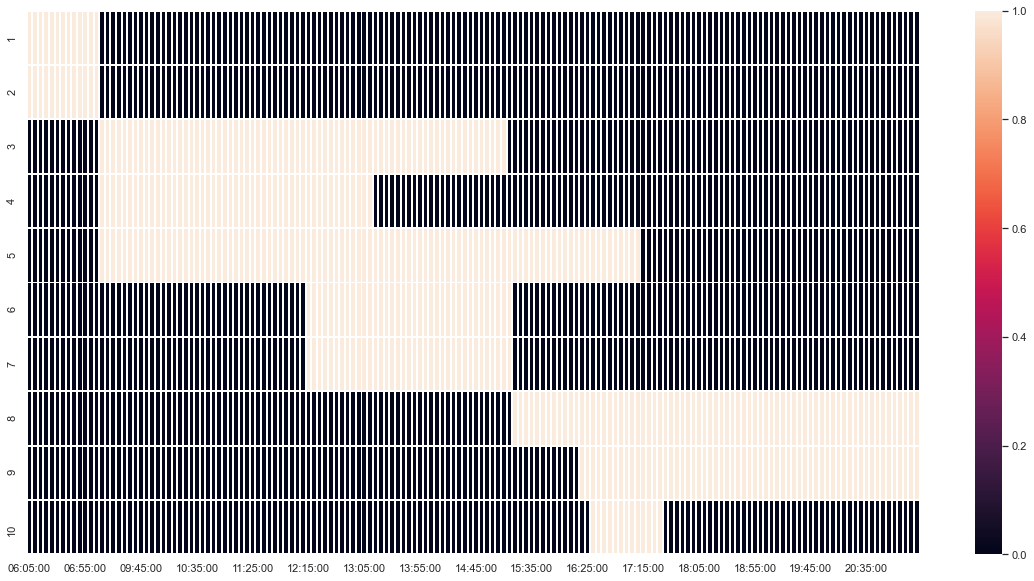

In [18]:
# Plot the turns in the airport
sns.set()
plt.figure(figsize=(20, 10))

snsdf = heatmapdf.T
g = sns.heatmap(snsdf, rasterized=True, xticklabels=10, linewidths=1)

In [19]:
# We don't need duplicate constraints (at different time buckets)
heatmapdf = heatmapdf.drop_duplicates()
heatmapdf.head()

,1,2,3,4,5,6,7,8,9,10
06:05:00,1,1,0,0,0,0,0,0,0,0
09:10:00,0,0,1,1,1,0,0,0,0,0
12:15:00,0,0,1,1,1,1,1,0,0,0
13:15:00,0,0,1,0,1,1,1,0,0,0
15:15:00,0,0,0,0,1,1,1,0,0,0


In [20]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    for g in compatible_gates[t]:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one (compatible) gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1

C:\Users\91909\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [21]:
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        # Only need to impose constraint if there is an overlap
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            print(row.name, ":", constraint_for_time_bucket)
            prob += constraint_for_time_bucket

06:05:00 : t1_gA1 + t2_gA1 <= 1
06:05:00 : t1_gB1 + t2_gB1 <= 1
09:10:00 : t3_gA1 + t4_gA1 + t5_gA1 <= 1
09:10:00 : t4_gA2 + t5_gA2 <= 1
09:10:00 : t3_gA3 + t4_gA3 + t5_gA3 <= 1
09:10:00 : t3_gB1 + t4_gB1 + t5_gB1 <= 1
09:10:00 : t4_gC1 + t5_gC1 <= 1
09:10:00 : t4_gC2 + t5_gC2 <= 1
12:15:00 : t3_gA1 + t4_gA1 + t5_gA1 + t6_gA1 + t7_gA1 <= 1
12:15:00 : t4_gA2 + t5_gA2 + t6_gA2 <= 1
12:15:00 : t3_gA3 + t4_gA3 + t5_gA3 + t6_gA3 <= 1
12:15:00 : t3_gB1 + t4_gB1 + t5_gB1 + t6_gB1 + t7_gB1 <= 1
12:15:00 : t4_gC1 + t5_gC1 + t6_gC1 <= 1
12:15:00 : t4_gC2 + t5_gC2 + t6_gC2 <= 1
13:15:00 : t3_gA1 + t5_gA1 + t6_gA1 + t7_gA1 <= 1
13:15:00 : t5_gA2 + t6_gA2 <= 1
13:15:00 : t3_gA3 + t5_gA3 + t6_gA3 <= 1
13:15:00 : t3_gB1 + t5_gB1 + t6_gB1 + t7_gB1 <= 1
13:15:00 : t5_gC1 + t6_gC1 <= 1
13:15:00 : t5_gC2 + t6_gC2 <= 1
15:15:00 : t5_gA1 + t6_gA1 + t7_gA1 <= 1
15:15:00 : t5_gA2 + t6_gA2 <= 1
15:15:00 : t5_gA3 + t6_gA3 <= 1
15:15:00 : t5_gB1 + t6_gB1 + t7_gB1 <= 1
15:15:00 : t5_gC1 + t6_gC1 <= 1
15:15:00 : 

In [22]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

Status:  Optimal
Minimised Cost:  None


In [23]:
# Create a function that we can call to visualise
def plot_gantt_chart(allocated_turns, lp_variable_outcomes, min_bucket=5):
    
    # Assign gate
    for alloc in lp_variable_outcomes:
        if lp_variable_outcomes[alloc].varValue:
            allocated_turns.set_value(allocated_turns['turn_no'] == alloc[0], 'gate', alloc[-1])
                
    # Create time-series between arrival of first plane and departure of last
    time_series = pd.Series(True, index= pd.date_range(
            start=turns2.inbound_arrival.min(),
            end=turns2.outbound_departure.max(),
            freq=pd.offsets.Minute(min_bucket)))

    # Truncate full time-series to [inbound_arrival, outbound_departure]
    def trunc_ts(series):
        return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])

    # Allocations heat-map
    allocheatmapdf = allocated_turns.apply(trunc_ts, axis=1).T
    allocheatmapdf.columns = allocated_turns['turn_no'].get_values()
    allocheatmapdf = allocheatmapdf.fillna(0).astype(int)
    allocheatmapdf.index = allocheatmapdf.index.time
    
    # Replace values with col-names
    for col in list(allocheatmapdf.columns):
        allocheatmapdf.loc[allocheatmapdf[col] > 0, col] = col
          
    # Columns are now stands
    allocheatmapdf.columns = allocated_turns['gate'].get_values()  
    trans = allocheatmapdf.T

    # These will never overlap given the constraints
    plt_df = trans.groupby(trans.index).sum()

    # Plot
    sns.set()
    plt.figure(figsize=(20, 10))
    g = sns.heatmap(plt_df, xticklabels=10, cmap='nipy_spectral')

In [24]:
# Remind ourselves of the allocations:
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

Turn 1 assigned to gate A3
Turn 2 assigned to gate A1
Turn 3 assigned to gate A3
Turn 4 assigned to gate A2
Turn 5 assigned to gate B1
Turn 6 assigned to gate C1
Turn 7 assigned to gate A1
Turn 8 assigned to gate A1
Turn 9 assigned to gate A2
Turn 10 assigned to gate C2


In [ ]:
def plot_chart_gantt:
    plot_chart_gantt(allocated_turns, lp_variable_outcomes, min_bucket=5)

  
    for alloc in lp_variable_outcomes:
        if lp_variable_outcomes[alloc].varvalue:
            allocated_turns.to_numpy(allocated_turns['turn_no']==alloc[0],'gate',alloc[-1])